## Reliability Statistics Notebook

This Jupyter notebook shows how to compute reliability engineering 
statistics (reliability, confidence, and assurance) using the
[relistats library](https://github.com/sanjaymjoshi/relistats) for
finite population size.

This notebook was used to generate the plots and tables in the paper:

S.M. Joshi, "TBD: Computation of Reliability Statistics for Success-Failure Experiments,"
[TBD: arXiv:2303.03167](https://doi.org/10.48550/arXiv.2303.03167), March 2023.
  

In [ ]:
# For use on google colab
# You can use `pipenv install` for local use and not execute this cell
!pip install relistats


## Set up
Run the follow cell first to import packages needed.

In [2]:

from relistats.binom_fin import assur_fin, conf_fin, reli_fin
from relistats.binomial import assurance, confidence, reliability
import matplotlib.pyplot as plt
from tabulate import tabulate

#table_format = "latex" # for paper
table_format = "simple" # for notebook


## Reliability

Reliability is probability of success. For success-failure experiments or test units
that either pass or fail, the samples typically have 'binomial distribution'. They are
assumed to be independent (one sample passing or failing has no effect on another sample)
and identically distributed (the reliability is same for each sample).

The math assumes infinite number of samples, but we can get access to only a finite
number of samples. By observing the number of successes and failures, we can compute an
estimate of reliability. Based on the number of samples, we qualify the quality of this
estimate using 'confidence'. Then we can say something like "we have 95% confidence that
the reliability is at least about 74% if we see zero failures in 10 samples" (see plot and
table generated by the block below).

These numbers, however, are for infinite population size. In practical world, we almost
always deal with finite population sizes. For example, suppose we computed the above
statistics for reliability of a new part that we want to manufacture. Before we sign-up
for unlimited number of units, it is a good idea to test the waters with a small number
of units. Suppose we want to make only 40 units in the first batch, are the numbers
still the same? Fortunately, they are better!

In the block below, the size of population, m, varies from 20 to 40 in steps of 10. Let's see
how the reliability changes as we increase the confidence from 75% to 99%. If you are using this
notebook on Google Colab, you can change these numbers on the right and see how the plot
and table changes.

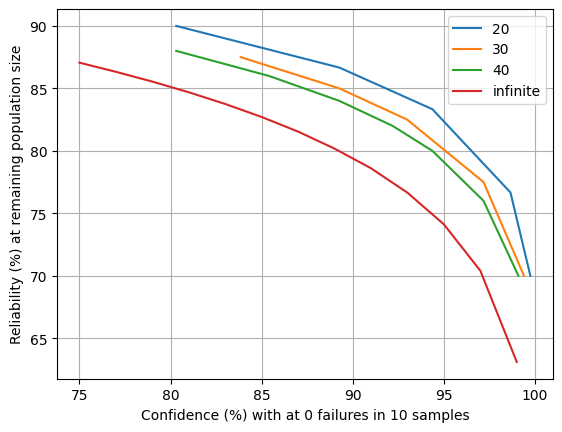

                                                                  20    30    40
--  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
 0  90.0  90.0  90.0  86.7  86.7  86.7  86.7  86.7  83.3  83.3  76.7  76.7  70.0
 1  87.5  87.5  87.5  87.5  87.5  85.0  85.0  85.0  82.5  77.5  77.5  77.5  70.0
 2  88.0  88.0  88.0  86.0  86.0  86.0  84.0  84.0  82.0  80.0  76.0  76.0  70.0


In [6]:
#@title Reliability computations { vertical-output: true }
n = 10 #@param {type:"integer"}
f = 0 #@param {type:"integer"}
m_start = 20 #@param {type:"integer"}
m_end = 40 #@param {type:"integer"}
m_step = 10 #@param {type:"integer"}

c_start = 75 #@param {type:"integer"}
c_end = 99 #@param {type:"integer"}
c_step = 2 #@param {type:"integer"}

all_m = list(range(m_start, m_end+m_step, m_step))
all_c = range(c_start, c_end+c_step, c_step)

all_r = []

for m in all_m:
  rr = []
  cc = []
  for c in all_c:
    r, c2 = reli_fin(n, f, c/100, m)
    cc.append(c2*100)
    rr.append(r*100)
  plot_label = m
  plt.plot(cc, rr, label=plot_label)
  all_r.append(rr)

# Infinite samples
rr_inf = [reliability(n,f,c/100)*100 for c in all_c]
plt.plot(all_c, rr_inf, label="infinite")
plt.ylabel('Reliability (%) at remaining population size')
plt.xlabel(f'Confidence (%) with at {f} failures in {n} samples')
plt.legend()
plt.grid()
plt.show()

# Doesn't make sense to print table of confidence and reliability in this block
# print(tabulate(all_r, headers=all_m, tablefmt=table_format, floatfmt=".1f", showindex="always"))

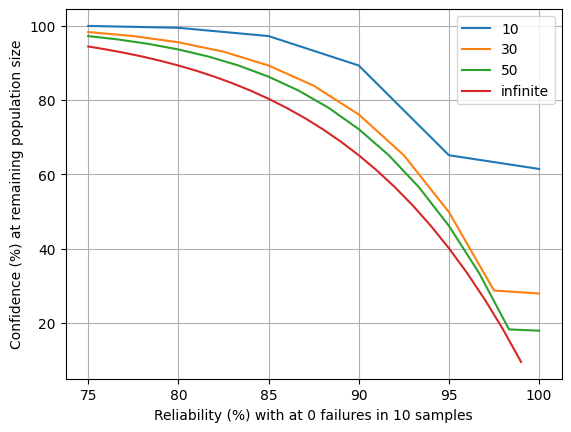

In [4]:
#@title Confidence computations { vertical-output: true }
n = 10 #@param {type:"integer"}
f = 0 #@param {type:"integer"}
m_start = 10 #@param {type:"integer"}
m_end = 50 #@param {type:"integer"}
m_step = 20 #@param {type:"integer"}

r_start = 75 #@param {type:"integer"}
r_end = 99 #@param {type:"integer"}
r_step = 1 #@param {type:"integer"}

all_m = list(range(m_start, m_end+m_step, m_step))
all_r = range(r_start, r_end+r_step, r_step)

all_c = []

for m in all_m:
  rr = []
  cc = []
  for r in all_r:
    c, r2 = conf_fin(n, f, r/100, m)
    cc.append(c*100)
    rr.append(r2*100)
    #print(n, f, r/100, m, c, r2)
  plot_label = m if m is not None else "infinite"
  plt.plot(rr, cc, label=plot_label)
  #print(rr, cc)

# Infinite samples
cc_inf = [confidence(n,f,r/100)*100 for r in all_r]
plt.plot(all_r, cc_inf, label="infinite")
plt.ylabel('Confidence (%) at remaining population size')
plt.xlabel(f'Reliability (%) with at {f} failures in {n} samples')
plt.legend()
plt.grid()
plt.show()

#print(tabulate(all_r, headers=all_m, tablefmt=table_format, floatfmt=".1f", showindex="always"))

## Confidence

Confidence in reliability is probability that the actual reliability of the whole,
infinite, population is at least the estimated reliability. 

As the number of samples increases, the confidence in reliability value also increases.
For the same number of samples, the confidence in minimum reliability increases as the
reliability level drops. You can see this behaviour in the plot and table below.

In the block below, the number of samples vary from 10 to 100 in steps of 10 and the
number of failures vary from 0 to 5. The minimum reliability level is held constatnt
at 90%. If you are using this notebook on Google Colab, you can change these numbers on
the right and see how the plot and table changes.

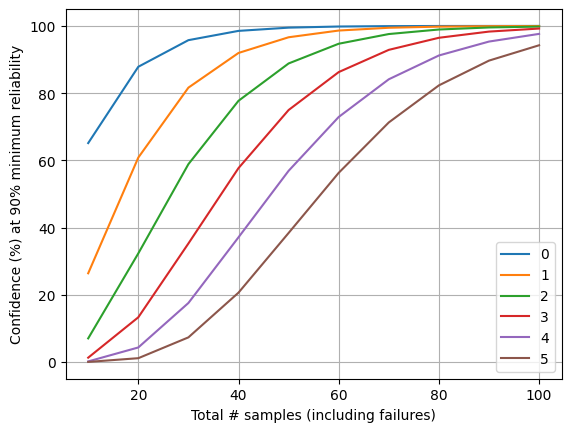

      10    20    30    40    50    60    70     80     90    100
--  ----  ----  ----  ----  ----  ----  ----  -----  -----  -----
 0  65.1  87.8  95.8  98.5  99.5  99.8  99.9  100.0  100.0  100.0
 1  26.4  60.8  81.6  92.0  96.6  98.6  99.5   99.8   99.9  100.0
 2   7.0  32.3  58.9  77.7  88.8  94.7  97.6   98.9   99.5   99.8
 3   1.3  13.3  35.3  57.7  75.0  86.3  92.9   96.5   98.3   99.2
 4   0.2   4.3  17.5  37.1  56.9  72.9  84.1   91.2   95.3   97.6
 5   0.0   1.1   7.3  20.6  38.4  56.3  71.3   82.3   89.7   94.2


In [11]:
#@title Confidence calculations { vertical-output: true }
n_start = 10 #@param {type:"integer"}
n_end = 100 #@param {type:"integer"}
n_step = 10 #@param {type:"integer"}
f_start = 0 #@param {type:"integer"}
f_end = 5 #@param {type:"integer"}
f_step = 1 #@param {type:"integer"}
reli_percent = 90 #@param {type:"integer"}

N = range(n_start, n_end+n_step, n_step) # number of samples
F = range(f_start, f_end+f_step, f_step) # number of failures
r = reli_percent/100 # reliability
all_c = []
for f in F:
  cc =  [100 *confidence(n, f, r) for n in N]
  plt.plot(N, cc)
  all_c.append(cc)

plt.ylabel(f'Confidence (%) at {reli_percent}% minimum reliability')
plt.xlabel('Total # samples (including failures)')
#plt.title('Confidence Level for Number of Failures')
plt.legend(F)
plt.grid()
plt.show()

print(tabulate(all_c, headers=N, tablefmt=table_format, floatfmt=".1f", showindex="always"))

## Assurance

Assurance simplifies reliability and confidence by setting both of them the same.
The result is just one number that is easier to communicate. For example, 90% assurance
means 90% reliability with 90% confidence. Given the number of samples and number of
failures, assurance is just one number.

As the number of samples increases, the assurance improves. You can see this behavior
in the plot and table below.

In the block below, the number of samples vary from 10 to 100 in steps of 10 and the
number of failures vary from 0 to 5. If you are using this notebook on Google Colab,
you can change these numbers on the right and see how the plot and table changes.

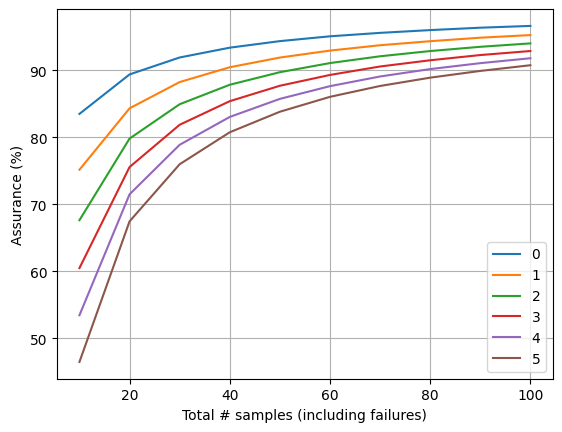

      10    20    30    40    50    60    70    80    90    100
--  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----
 0  83.5  89.4  91.9  93.4  94.4  95.1  95.6  96.0  96.4   96.7
 1  75.2  84.3  88.3  90.5  91.9  93.0  93.8  94.4  94.9   95.3
 2  67.7  79.8  85.0  87.9  89.7  91.1  92.1  92.9  93.5   94.0
 3  60.5  75.6  81.9  85.4  87.7  89.3  90.6  91.5  92.3   92.9
 4  53.5  71.5  78.9  83.1  85.8  87.7  89.1  90.2  91.1   91.8
 5  46.5  67.5  76.0  80.8  83.8  86.1  87.7  88.9  89.9   90.8


In [12]:
#@title Assurance computations { vertical-output: true }
n_start = 10 #@param {type:"integer"}
n_end = 100 #@param {type:"integer"}
n_step = 10 #@param {type:"integer"}
f_start = 0 #@param {type:"integer"}
f_end = 5 #@param {type:"integer"}
f_step = 1 #@param {type:"integer"}

N = range(n_start, n_end+n_step, n_step) # number of samples
F = range(f_start, f_end+f_step, f_step) # number of failures
all_a = []
for f in F:
  aa =  [100 *assurance(n, f) for n in N]
  plt.plot(N, aa)
  all_a.append(aa)

plt.ylabel(f'Assurance (%)')
plt.xlabel('Total # samples (including failures)')
#plt.title('Confidence Level for Number of Failures')
plt.legend(F)
plt.grid()
plt.show()

print(tabulate(all_a, headers=N, tablefmt=table_format, floatfmt=".1f", showindex="always"))

## Accuracy of Reliability Approximation

This section was created to assess the quality of reliability approximations using three methods:
- Wilson Score Interval
- Wilson Score Interval with Continuity Correction
- Numerical optimization
See the paper referenced above for details.

The numerical optimization is accurate and fast technique to calculate reliability or assurance.

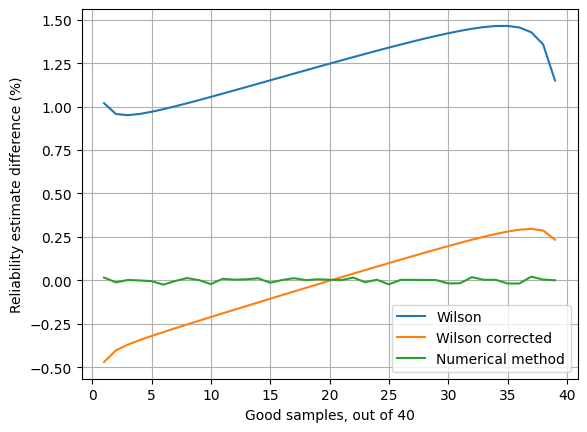

In [13]:
#@title Accuracy of Closed Form Reliability Computations { vertical-output: true }
n = 40 #@param {type:"integer"}

from relistats.binomial import _wilson_lower, _wilson_lower_corrected, reliability_optim


rmat = []
all_ns = range(1,n)
for ns in all_ns:
  r = ns/n
  c = confidence(n, n-ns, r)
  rw = _wilson_lower(r, n, c)
  rwc = _wilson_lower_corrected(r, n, c)
  roptim = reliability_optim(n, n-ns, c)

  rmat.append([(rw-r)*100, (rwc-r)*100, (roptim-r)*100 ])

plt.plot(all_ns, rmat)
  
plt.legend(['Wilson', 'Wilson corrected', 'Numerical method'])
plt.xlabel(f'Good samples, out of {n}')
plt.ylabel('Reliability estimate difference (%)')
#plt.title('Accuracy of Wilson Score Interval Methods')
plt.grid()
plt.show()

